# Import Packages

In [1]:
import torch
import numpy as np
from PIL import Image
import random
from torch.utils.data import Dataset
import os
import os.path as osp
import torch.optim as optim
from monai.losses import DiceFocalLoss
from monai.networks import one_hot
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from torchvision import transforms as T
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt
from segment_anything.modeling import *
from functools import partial
import torch.nn as nn
from sklearn.metrics import confusion_matrix, jaccard_score

from datetime import datetime

# Settings

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device:{device}")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.enabled = True

using device:cuda


In [4]:
# set seeds
torch.manual_seed(2023)
torch.cuda.empty_cache()

# Transforms

In [5]:
def pad_if_smaller(img, size, fill=0):
    min_size = min(img.size)
    if min_size < size:
        ow, oh = img.size
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = F.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target, box):
        for t in self.transforms:
            image, target, box = t(image, target, box)
        return image, target, box


class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target, box):
        size = random.randint(self.min_size, self.max_size)
        old_w, old_h = image.size
        image = F.resize(image, size)
        target = F.resize(target, size, interpolation=Image.NEAREST)
        new_w, new_h = image.size
        # Scale box coordinates
        scale_x = new_w / old_w
        scale_y = new_h / old_h
        box = box * [scale_x, scale_y, scale_x, scale_y]
        return image, target, box

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target, box):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
            w = image.size[0]
            # Adjust box for horizontal flip
            box = [w - box[2], box[1], w - box[0], box[3]]
        return image, target, box


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target, box):
        image = pad_if_smaller(image, self.size)
        target = pad_if_smaller(target, self.size, fill=255)
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        i, j, h, w = crop_params
        image = F.crop(image, i, j, h, w)
        target = F.crop(target, i, j, h, w)
        box = [max(0,box[0] - j), max(0,box[1] - i), min(box[2] - j,image.size[0]), min(box[3] - i,image.size[1])]
        return image, target, box


class ToTensor(object):
    def __call__(self, image, target, box):
        image = F.to_tensor(image)
        target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
        return image, target, box


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target, box):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target, box


class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, image, target, box):
        image = T.ColorJitter(brightness=self.brightness,
                              contrast=self.contrast,
                              saturation=self.saturation,
                              hue=self.hue)(image)
        return image, target, box


class RandomVerticalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target, box):
        if random.random() < self.flip_prob:
            image = F.vflip(image)
            target = F.vflip(target)
            h = image.size[1]
            # Adjust box for vertical flip
            box = [box[0], h - box[3], box[2], h - box[1]]
        return image, target, box

In [6]:
def get_dataset(imgdir, maskdir=None, oversample_factors = {1:16,3:8,4:8,5:32}, train=True, val=False, test=False,
                transforms=None, indices = None):
    dataset = Gleason(imgdir=imgdir, maskdir=maskdir, oversample_factors = oversample_factors,train=train,
                      val=val, test=test, transforms=transforms,indices = indices)

    return dataset


def get_transform(train):
    base_size = 1536
    crop_size = 1024
    if train:
        min_size,max_size = 0.5*base_size, 2.0*base_size
    else:
        min_size = max_size = crop_size
    transforms = []
    transforms.append(RandomResize(min_size, max_size))
    if train:
        transforms.append(ColorJitter(0.5, 0.5, 0.5, 0.5))
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))
        transforms.append(RandomCrop(crop_size))
    transforms.append(ToTensor())
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]))

    return Compose(transforms)

# Dataset

In [7]:
label_mapping = {0:0,1: 1, 3: 2, 4: 3, 5: 4}

class Gleason(Dataset):
    def __init__(self, imgdir, maskdir=None, oversample_factors = {}, train=True, val=False,
                 test=False, transforms=None,indices=None):
        super(Gleason, self).__init__()
        self.imgdir = imgdir
        self.maskdir = maskdir
        self.oversample_factors = oversample_factors
        self.imglist = sorted(os.listdir(imgdir))[1:]
        self.masklist = [item.replace('.jpg', '_classimg_nonconvex.png') for item in self.imglist]
        if indices is not None:
            self.masklist = [self.masklist[i] for i in indices]
        self.oversampled_files = self._apply_oversampling()
        self.train = train
        self.val = val
        self.test = test
        self.transforms = transforms
        
    def _apply_oversampling(self):
        oversampled_files = []
        for file in self.masklist:
            gt_file = osp.join(self.maskdir, file)
            gt = Image.open(gt_file)
            unique_classes = np.unique(np.array(gt))
            if max(unique_classes)<6:
                factor = max(self.oversample_factors.get(cls,1) for cls in unique_classes)
                oversampled_files.extend([file]*factor)
        return oversampled_files

    def __len__(self):
        return len(self.oversampled_files)

    def __getitem__(self, idx):
        image = Image.open(osp.join(self.imgdir, self.oversampled_files[idx].replace('_classimg_nonconvex.png','.jpg')))
        mask = Image.open(osp.join(self.maskdir, self.oversampled_files[idx]))
        
        y_indices, x_indices = np.where(np.array(mask) > 0)
        if x_indices.size > 0 and y_indices.size > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            H, W = np.array(mask).shape
            x_min = max(0, x_min - random.randint(0, 60))
            x_max = min(W, x_max + random.randint(0, 60))
            y_min = max(0, y_min - random.randint(0, 60))
            y_max = min(H, y_max + random.randint(0, 60))
            box = np.array([x_min, y_min, x_max, y_max])
        else:
            box = np.array([0, 0, 0,0])
        if self.transforms and not self.test:
            image, mask, box = self.transforms(image, mask, box)
            if box[0]>=box[2] or box[1]>=box[3]:
                box = np.array([0,0,0,0])

        gt = np.vectorize(lambda x: label_mapping.get(x, 5))(np.array(mask))
        mask = torch.as_tensor(gt, dtype=torch.int64)
        
        if self.test:
            return image
        else:
            return F.crop(image, 0, 0, 1024, 1024), F.crop(mask, 0, 0, 1024, 1024), np.floor(np.array(box))
            

In [8]:
dataset = get_dataset(imgdir='../../data/TrainImgs',
                          maskdir='../../data/labels',
                          oversample_factors = {},
                          train=False,
                          val=False,
                          test=False,
                          transforms=get_transform(train=False))

In [9]:
def split_train_valid(dataset, test_size=0.1, random_state=42):
    # 提取每张图片中包含的主要类别 (按最大值决定)
    labels = []
    for file in dataset.masklist:
        gt = Image.open(osp.join(dataset.maskdir, file))
        max_class = np.max(np.array(gt))
        labels.append(max_class)

    # 使用 StratifiedShuffleSplit 进行分层抽样
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    indices = np.arange(len(labels))
    train_indices, valid_indices = next(sss.split(indices, labels))
    
    return train_indices, valid_indices


In [10]:
train_indices, valid_indices = split_train_valid(dataset, test_size=0.1)

In [11]:
train_dataset = get_dataset(imgdir='../../data/TrainImgs',
                          maskdir='../../data/labels',
                          oversample_factors = {1:24,3:12,4:12,5:48},
                          train=True,
                          val=False,
                          test=False,
                          transforms=get_transform(train=True),indices = train_indices)

In [12]:
valid_dataset = get_dataset(imgdir='../../data/TrainImgs',
                          maskdir='../../data/labels',
                          oversample_factors = {1:1,3:1,4:1,5:1},
                          train=False,
                          val=True,
                          test=False,
                          transforms=get_transform(train=False),indices = valid_indices)

# Data Loader

In [13]:
def cat_list(images, fill_value=0):
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_imgs = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[..., :img.shape[-2], :img.shape[-1]].copy_(img)
    return batched_imgs


def collate_fn(batch):
    images, targets, box = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=0)
    batched_targets = cat_list(targets, fill_value=255)
    return batched_imgs, batched_targets, box


train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=2,
        shuffle=True, num_workers=10,
        collate_fn=collate_fn, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=2,
        shuffle=False, num_workers=10,
        collate_fn=collate_fn, drop_last=True)

In [14]:
#currently show_mask function only shows the different between zero and non-zero
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )

/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pyt

torch.Size([2, 3, 1024, 1024]) torch.Size([2, 1024, 1024]) (array([   0.,    0., 1024., 1024.]), array([   0.,    0., 1024., 1024.]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.9647058823529413].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84523803..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9764705882352942].


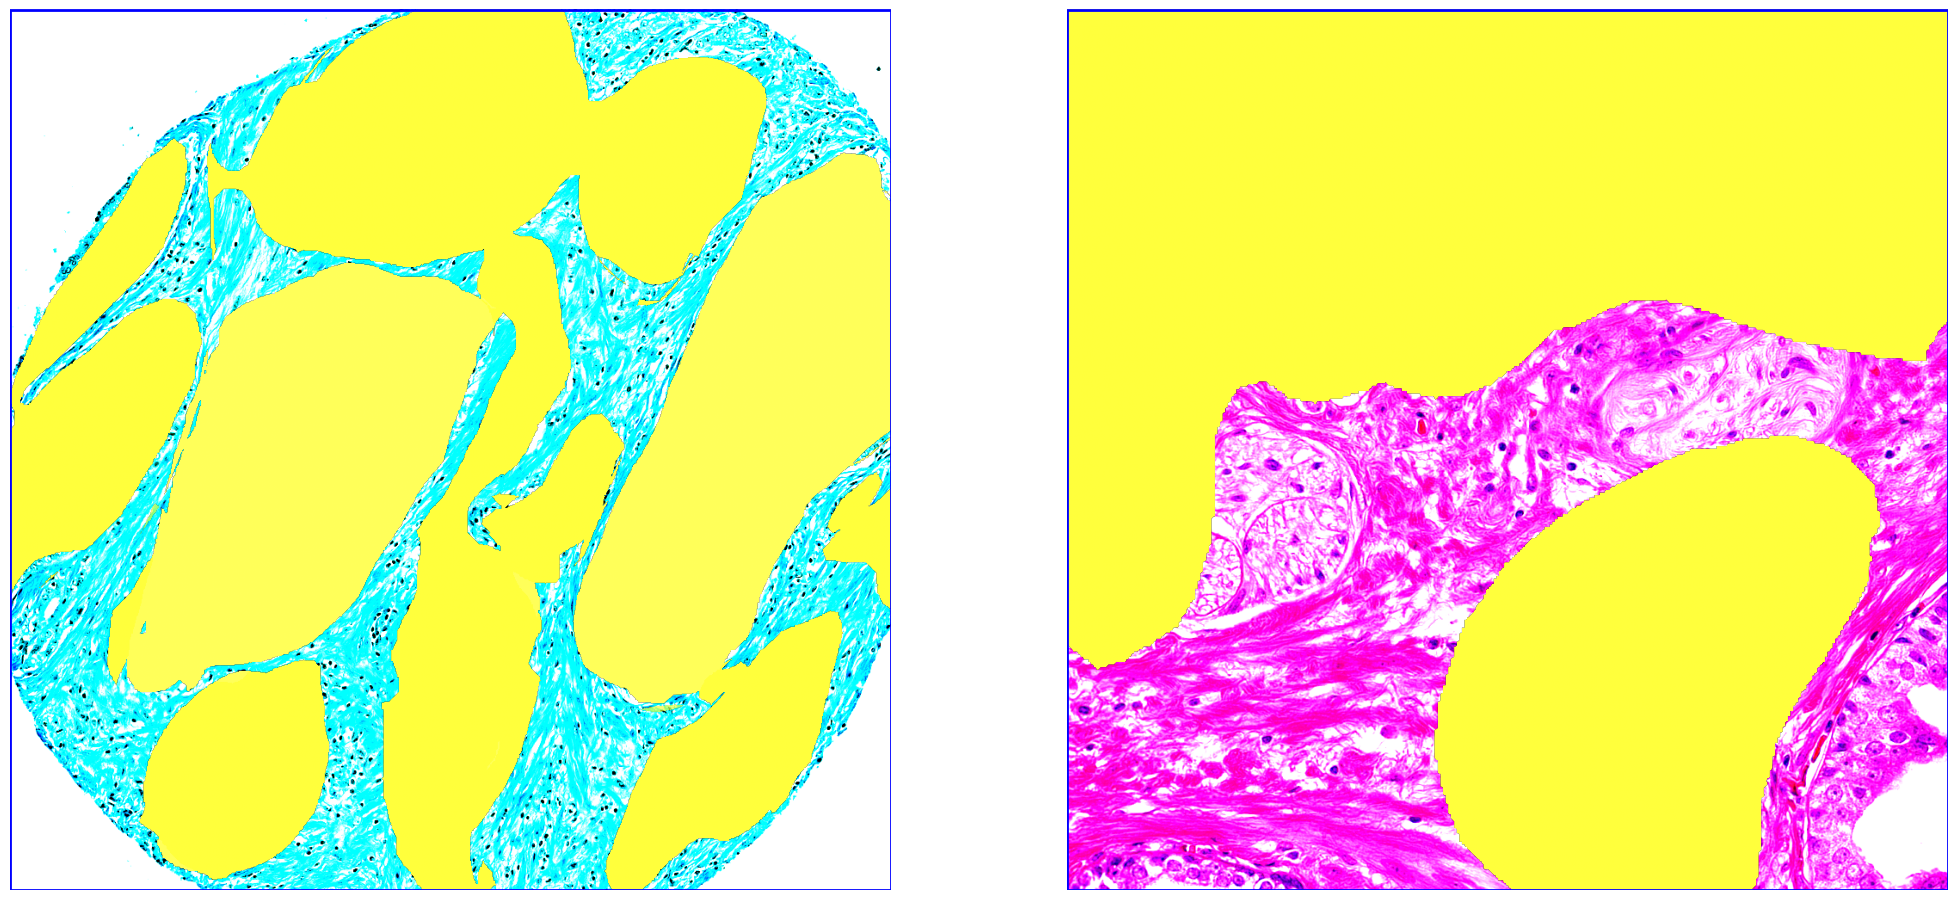

In [15]:
for step, (image, gt, bboxes) in enumerate(train_dataloader):
    print(image.shape, gt.shape, bboxes)
    # show the example
    _, axs = plt.subplots(1, 2, figsize=(25, 25))
    axs[0].imshow(image[0].cpu().permute(1, 2, 0).numpy())
    show_mask(gt[0].cpu().numpy(), axs[0])
    show_box(bboxes[0], axs[0])
    axs[0].axis("off")
    # set title
    axs[1].imshow(image[1].cpu().permute(1, 2, 0).numpy())
    show_mask(gt[1].cpu().numpy(), axs[1])
    show_box(bboxes[1], axs[1])
    axs[1].axis("off")
    # set title
    plt.show()
    plt.subplots_adjust(wspace=0.01, hspace=0)
    plt.close()
    break

# Model

In [16]:
checkpoint = 'medsam_vit_b.pth'
pretrained_state_dict = torch.load(checkpoint,map_location=device)

/tmp/ipykernel_25418/995072830.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state_dict = torch.load(checkpoint,map_location=device)


In [17]:
class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box, dropout_prob=0.2):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        image_embedding = nn.functional.dropout(image_embedding, p=dropout_prob, training=self.training)

        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(np.array(box), dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        #sparse_embeddings = nn.functional.dropout(sparse_embeddings, p=dropout_prob, training=self.training)
        #dense_embeddings = nn.functional.dropout(dense_embeddings, p=dropout_prob, training=self.training)
        
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=True,
        )
        low_res_masks = nn.functional.dropout(low_res_masks, p=dropout_prob, training=self.training)
        ori_res_masks = nn.functional.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

In [18]:
encoder_global_attn_indexes = [2, 5, 8, 11]

num_class_sam_model = MedSAM(
    image_encoder=ImageEncoderViT(
        depth=12,
        embed_dim=768,
        img_size=1024,
        mlp_ratio=4,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
        num_heads=12,
        patch_size=16,
        qkv_bias=True,
        use_rel_pos=True,
        global_attn_indexes=encoder_global_attn_indexes,
        window_size=14,
        out_chans=256,
    ),
    mask_decoder=MaskDecoder(
        num_multimask_outputs=4,
        transformer=TwoWayTransformer(
            depth=2,
            embedding_dim=256,
            mlp_dim=2048,
            num_heads=8,
        ),
        transformer_dim=256,
        iou_head_depth=3,
        iou_head_hidden_dim=256,
    ),
    prompt_encoder=PromptEncoder(
        embed_dim=256,
        image_embedding_size=(64, 64),
        input_image_size=(1024, 1024),
        mask_in_chans=16,
    )
)

num_class_sam_model = num_class_sam_model.to(device)
num_class_model_state_dict = num_class_sam_model.state_dict()

In [19]:
for name, param in pretrained_state_dict.items():
    if name in num_class_model_state_dict and num_class_model_state_dict[name].shape == param.shape:
        num_class_model_state_dict[name] = param
# 加载适配的state_dict:
num_class_sam_model.load_state_dict(num_class_model_state_dict, strict=False)
num_class_sam_model.train()

MedSAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
   

# Train

In [20]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        N = target.size(0)
        smooth = 1

        input_flat = input.view(N, -1)
        target_flat = target.view(N, -1)

        intersection = input_flat * target_flat

        loss = (intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
        loss = 1 - loss.sum() / N

        return loss

class MulticlassDiceLoss(nn.Module):
    """
    Requires one-hot encoded target. Applies DiceLoss on each class iteratively.
    Requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
    batch size and C is number of classes.
    """
    def __init__(self, ignore_index = None):
        super(MulticlassDiceLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, input, target):
        target = target.view(-1,1,1024,1024)
        target = one_hot(target,num_classes = 6)
        input = input.argmax(1).view(-1,1,1024,1024)
        input = one_hot(input,num_classes = 5)
        C = target.shape[1]


        dice = DiceLoss()
        totalLoss = 0
        validClasses = 0


        for i in range(C):
            if self.ignore_index is not None and i in self.ignore_index:
                continue
            diceLoss = dice(input[:, i], target[:, i])
            totalLoss += diceLoss
            validClasses += 1

        if validClasses == 0:
            raise ValueError("All classes are ignored. Ensure ignore_index excludes at least one class.")

        return totalLoss / validClasses
seg_loss = MulticlassDiceLoss(ignore_index=[5])


In [21]:
ce_loss = nn.CrossEntropyLoss(ignore_index = 5, weight=torch.tensor([1,1,1,1,3], dtype=torch.float).to(device))
optimizer = torch.optim.SGD(
        num_class_sam_model.parameters(),
        lr=1e-4, momentum=0.9, weight_decay=1e-4)


In [ ]:
# 定义模型检查点的路径
#checkpoint_dir = 'multiclassifier_info_preprocessed'
checkpoint_dir = ''
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
best_model_path = os.path.join(checkpoint_dir,"best_model.pth")
#os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 1000
train_losses = []
val_losses = []
best_val_loss = float('inf')

torch.cuda.empty_cache()
scaler = torch.amp.GradScaler()

# 尝试加载之前的检查点
start_epoch = 0
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    num_class_sam_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"Resuming training from epoch {start_epoch}")



# 开始训练
for epoch in range(start_epoch, num_epochs):
    num_class_sam_model.train()
    train_epoch_loss = 0.0

    for step, (image, gt, boxes) in enumerate(tqdm(train_dataloader)):
        torch.cuda.empty_cache() 
        optimizer.zero_grad()
        image, gt = image.to(device), gt.to(device)
        gt = gt.squeeze(1)  # shape: (2, 1024, 1024)

        with torch.amp.autocast(device_type="cuda"):
            medsam_pred = num_class_sam_model(image, boxes)
            loss = 0.9*ce_loss(medsam_pred, gt) + 0.1*seg_loss(medsam_pred, gt)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        train_epoch_loss += loss.item()

    # 计算并保存每个epoch的平均损失
    train_epoch_loss /= step
    train_losses.append(train_epoch_loss)
    print(
        f'Time: {datetime.now().strftime("%Y%m%d-%H%M")}, Epoch: {epoch}, train Loss: {train_epoch_loss}'
    )


    
    #validation
    num_class_sam_model.eval()
    val_epoch_loss = 0.0

    

    num_classes = 5
    total_conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    iou_numerator = np.zeros(num_classes, dtype=np.int64)
    iou_denominator = np.zeros(num_classes, dtype=np.int64)

    for step,(image,gt,boxes) in enumerate(tqdm(valid_dataloader)):
        torch.cuda.empty_cache()
        image, gt = image.to(device), gt.to(device)
        gt = gt.squeeze(1)  # shape: (2, 1024, 1024)
        with torch.no_grad():
            medsam_pred = num_class_sam_model(image, boxes)
            val_loss = 0.9*ce_loss(medsam_pred, gt) + 0.1*seg_loss(medsam_pred, gt)
            val_epoch_loss+=val_loss.item()

            final_pred = medsam_pred.argmax(1).cpu().numpy()
            gts = gt.cpu().numpy()
        
            # 逐批次更新混淆矩阵
            for i in range(final_pred.shape[0]):  # 遍历 batch 内每张图片
                conf_matrix = confusion_matrix(gts[i].flatten(), final_pred[i].flatten(), labels=range(num_classes))
                total_conf_matrix += conf_matrix
        
                # 累积 IoU 的交集和并集
                for cls in range(num_classes):
                    intersection = np.logical_and(final_pred[i] == cls, gts[i] == cls).sum()
                    union = np.logical_or(final_pred[i] == cls, gts[i] == cls).sum()
           
                    iou_numerator[cls] += intersection
                    iou_denominator[cls] += union

    val_epoch_loss /= step
    val_losses.append(val_epoch_loss)
    print(
        f'Time: {datetime.now().strftime("%Y%m%d-%H%M")}, Epoch: {epoch}, validation Loss: {val_epoch_loss}'
    )
    # 计算每个类别的 IoU
    iou_scores = iou_numerator / (iou_denominator + 1e-10)
    
    # 计算平均 IoU
    mean_iou = total_conf_matrix.trace()/total_conf_matrix.sum()
    
    # 打印结果
    print("Confusion Matrix:")
    print(total_conf_matrix)
    
    print("\nIoU Scores for Each Class:")
    for cls, iou in enumerate(iou_scores):
        print(f"Class {cls}: IoU = {iou:.4f}")
    
    print(f"\Total IoU: {mean_iou:.4f}")
    
    if val_epoch_loss<best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(num_class_sam_model.state_dict(),best_model_path)
        print(f"New best model saved with validation loss: {best_val_loss}")
    
        
    # 保存模型状态
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': num_class_sam_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }, checkpoint_path)


/tmp/ipykernel_25418/85274087.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 51


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0046, Epoch: 51, train Loss: 0.5507400506219902


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0047, Epoch: 51, validation Loss: 0.5219202569939874
Confusion Matrix:
[[11068536    88641   368701   520906        0]
 [  229412   853641   203399    79173        0]
 [  145613      921  2052555  1212755        0]
 [  364519    68450   409822  6861332        0]
 [   13903      680        0   622865        0]]

IoU Scores for Each Class:
Class 0: IoU = 0.8647
Class 1: IoU = 0.5600
Class 2: IoU = 0.4672
Class 3: IoU = 0.6767
Class 4: IoU = 0.0000
\Total IoU: 0.8280
New best model saved with validation loss: 0.5219202569939874


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0110, Epoch: 52, train Loss: 0.5526065924529358


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0110, Epoch: 52, validation Loss: 0.5169712210243399
Confusion Matrix:
[[11148968    75122   310045   509271     3378]
 [  259914   895200   120619    89892        0]
 [  181258    10485  2047145  1172956        0]
 [  410297    57813   425557  6809157     1299]
 [   13224      251        0   602836    21137]]

IoU Scores for Each Class:
Class 0: IoU = 0.8635
Class 1: IoU = 0.5931
Class 2: IoU = 0.4796
Class 3: IoU = 0.6756
Class 4: IoU = 0.0329
\Total IoU: 0.8313
New best model saved with validation loss: 0.5169712210243399


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0132, Epoch: 53, train Loss: 0.5464054182340197


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0132, Epoch: 53, validation Loss: 0.5032604458657178
Confusion Matrix:
[[11008104    76120   485344   475023     2193]
 [  250199   829411   223018    62997        0]
 [  128151     1166  2576602   705925        0]
 [  339829    24922   846642  6491922      808]
 [   14537      446        0   600872    21593]]

IoU Scores for Each Class:
Class 0: IoU = 0.8614
Class 1: IoU = 0.5649
Class 2: IoU = 0.5188
Class 3: IoU = 0.6799
Class 4: IoU = 0.0337
\Total IoU: 0.8316
New best model saved with validation loss: 0.5032604458657178


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0154, Epoch: 54, train Loss: 0.5431967670704798


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0154, Epoch: 54, validation Loss: 0.480448997833512
Confusion Matrix:
[[11069152   103401   537004   333681     3546]
 [  240861   895495   214672    14597        0]
 [  133018    10184  2619938   648704        0]
 [  375214    88830  1006128  6215058    18893]
 [   14457      967     6824   172454   442746]]

IoU Scores for Each Class:
Class 0: IoU = 0.8641
Class 1: IoU = 0.5707
Class 2: IoU = 0.5061
Class 3: IoU = 0.7004
Class 4: IoU = 0.6709
\Total IoU: 0.8441
New best model saved with validation loss: 0.480448997833512


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0216, Epoch: 55, train Loss: 0.5406762077113554


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0216, Epoch: 55, validation Loss: 0.5711339183829047
Confusion Matrix:
[[10937420    99842   388828   620694        0]
 [  223083   878972   164758    98812        0]
 [  124344     7352  1960183  1319965        0]
 [  267240    51587   303082  7082214        0]
 [   10664      872        0   625912        0]]

IoU Scores for Each Class:
Class 0: IoU = 0.8631
Class 1: IoU = 0.5763
Class 2: IoU = 0.4592
Class 3: IoU = 0.6830
Class 4: IoU = 0.0000
\Total IoU: 0.8289


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0237, Epoch: 56, train Loss: 0.5343706668398418


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0238, Epoch: 56, validation Loss: 0.524861288341609
Confusion Matrix:
[[11124726    96161   284268   540020     1609]
 [  260232   895434   136154    73805        0]
 [  160465    26982  1994812  1229585        0]
 [  361538    64733   389063  6888675      114]
 [   11958      628        0   621513     3349]]

IoU Scores for Each Class:
Class 0: IoU = 0.8663
Class 1: IoU = 0.5762
Class 2: IoU = 0.4726
Class 3: IoU = 0.6774
Class 4: IoU = 0.0052
\Total IoU: 0.8308


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0259, Epoch: 57, train Loss: 0.5322943424802491


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0259, Epoch: 57, validation Loss: 0.5039428133856166
Confusion Matrix:
[[11105281    98004   379416   457565     6518]
 [  274403   883093   164215    43914        0]
 [  150563    16238  2169050  1075993        0]
 [  375549    69644   514439  6737815     6676]
 [    9335     1336      740   272912   353125]]

IoU Scores for Each Class:
Class 0: IoU = 0.8638
Class 1: IoU = 0.5694
Class 2: IoU = 0.4852
Class 3: IoU = 0.7052
Class 4: IoU = 0.5427
\Total IoU: 0.8443


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0321, Epoch: 58, train Loss: 0.5333360449609166


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0321, Epoch: 58, validation Loss: 0.5274769135496833
Confusion Matrix:
[[11054641   103204   277728   609642     1569]
 [  237172   922309   123481    82663        0]
 [  170154    15812  1845452  1380426        0]
 [  277468    72010   276611  7077947       87]
 [   11262      661        0   622023     3502]]

IoU Scores for Each Class:
Class 0: IoU = 0.8675
Class 1: IoU = 0.5922
Class 2: IoU = 0.4512
Class 3: IoU = 0.6806
Class 4: IoU = 0.0055
\Total IoU: 0.8306


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

Time: 20250110-0343, Epoch: 59, train Loss: 0.5255476387108899


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered 

Time: 20250110-0343, Epoch: 59, validation Loss: 0.5251789404587313
Confusion Matrix:
[[10983779    51199   561191   449316     1299]
 [  235362   827699   290383    12181        0]
 [  102016      302  2256489  1053037        0]
 [  344286    47320   691826  6620624       67]
 [   11964       36      182   622986     2280]]

IoU Scores for Each Class:
Class 0: IoU = 0.8621
Class 1: IoU = 0.5652
Class 2: IoU = 0.4554
Class 3: IoU = 0.6727
Class 4: IoU = 0.0036
\Total IoU: 0.8222


  0%|          | 0/2125 [00:00<?, ?it/s]/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
/tmp/ipykernel_25418/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggere

In [3]:
from sklearn.metrics import cohen_kappa_score, f1_score


confusion_matrix = np.array([
    [11005674, 91086, 428167, 513313, 8544],
    [206727, 843312, 233498, 82088, 0],
    [136750, 5725, 2173016, 1096353, 0],
    [321315, 65620, 495645, 6772747, 48796],
    [8375, 340, 1237, 29083, 598413]
])

def calculate_metrics(confusion_matrix):
    """
    Calculates Cohen's kappa, macro-averaged F1-score, and micro-averaged F1-score.
    Combines macro-F1 and micro-F1 using their average.
    
    Args:
        confusion_matrix (np.ndarray): Confusion matrix (shape: [num_classes, num_classes])
        
    Returns:
        tuple: (Cohen's Kappa, Average F1 (Macro + Micro) / 2)
    """
    # Ensure input is a numpy array
    cm = np.array(confusion_matrix)
    
    # Number of classes
    num_classes = cm.shape[0]
    
    # Flatten the confusion matrix to calculate Cohen's kappa
    y_true = []
    y_pred = []
    for i in range(num_classes):
        for j in range(num_classes):
            y_true.extend([i] * cm[i, j])
            y_pred.extend([j] * cm[i, j])
    
    # Calculate Cohen's kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Calculate F1 scores
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)
    
    # Precision and Recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # F1-score for each class (macro)
    f1_per_class = 2 * precision * recall / (precision + recall + 1e-10)
    macro_f1 = np.mean(f1_per_class)
    
    # Micro F1-score
    total_tp = tp.sum()
    total_fp = fp.sum()
    total_fn = fn.sum()
    micro_precision = total_tp / (total_tp + total_fp + 1e-10)
    micro_recall = total_tp / (total_tp + total_fn + 1e-10)
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + 1e-10)
    
    # Combined metric
    avg_f1 = (macro_f1 + micro_f1) / 2
    
    return kappa, avg_f1, macro_f1, micro_f1

kappa, avg_f1, macro_f1, micro_f1 = calculate_metrics(confusion_matrix)

In [5]:
micro_f1

0.8500878810382568

In [26]:
kappa

0.770688805648496

In [27]:
avg_f1

0.829555004046174

In [28]:
kappa+avg_f1

1.6002438096946698

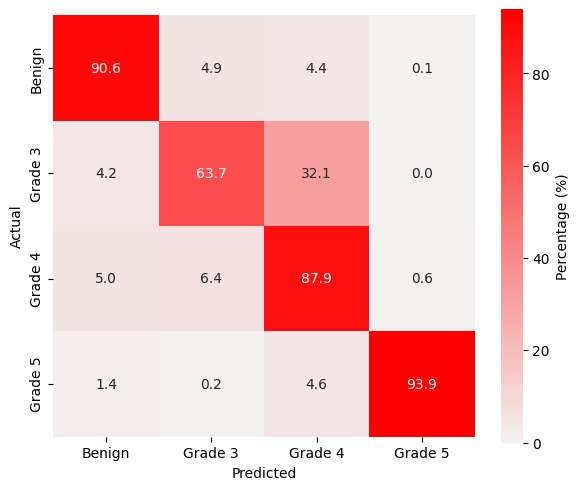

In [9]:
import seaborn as sns
# 原始混淆矩阵
confusion_matrix = np.array([
    [11005674, 91086, 428167, 513313, 8544],
    [206727, 843312, 233498, 82088, 0],
    [136750, 5725, 2173016, 1096353, 0],
    [321315, 65620, 495645, 6772747, 48796],
    [8375, 340, 1237, 29083, 598413]
])

# 合并前两行和列
processed_matrix = np.zeros((4, 4))

# 合并 Benign 类 (前两行和列)
processed_matrix[0, 0] = confusion_matrix[0:2, 0:2].sum()
processed_matrix[0, 1:] = confusion_matrix[0:2, 2:].sum(axis=0)
processed_matrix[1:, 0] = confusion_matrix[2:, 0:2].sum(axis=1)
processed_matrix[1:, 1:] = confusion_matrix[2:, 2:]

# 行归一化
normalized_matrix = processed_matrix / processed_matrix.sum(axis=1)[:, np.newaxis]
normalized_matrix = normalized_matrix * 100  # 转换为百分比

# 设置标签
labels = ['Benign', 'Grade 3', 'Grade 4', 'Grade 5']

# 创建热力图
plt.figure(figsize=(6, 5))
sns.heatmap(normalized_matrix, 
            annot=True, 
            fmt='.1f',
            cmap=sns.light_palette("red", as_cmap=True),
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Percentage (%)'},
            square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

# 调整布局
plt.tight_layout()
plt.show()